In [2]:
'''
import necessary packages
'''

## lung segmentation function
import numpy as np
#import pydicom
import os
import sys
import glob
import numpy as np
import cv2
from skimage.segmentation import clear_border
from scipy import ndimage
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label, regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage.filters import threshold_otsu
import itertools
from skimage.io import imshow

## image manipulation, plotting, saving
import os
import re
import imageio
from skimage import io, color
from skimage.color import rgb2gray
from skimage.io import imsave
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt



In [3]:
'''
define lung segmentation function
'''

def segment_lungs(im):
    """
    Using a 2D image as input (in the form of an array), this function will generate a binary mask and an output image that both only show the lungs.
    """
    ##### BINARIZE IMAGE
    # first anything <0 (as some images are negative)
    im_b = np.where(im<0, 0, im)
    #then based on otsu thresholding
    thresh = threshold_otsu(im_b)
    binary = im_b > thresh
    
    #invert the image to make the lungs the ROIs
#    binary = np.invert(binary)

    ##### GENERATE BORDER OF THE BINARIES
    cleared = clear_border(binary)
    
    ##### LABEL DISTINCT BODIES IN IMAGE
    label_image = label(cleared)

    ##### KEEP TWO LARGEST AREAS
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    
    ##### EROSION TO GET RID OF ARTIFACTS
#    selem = disk(4)
#    binary = binary_erosion(binary, selem)

    ##### DILATION TO BRING BACK LUNG INFORMATION
    selem = disk(4)
    binary = binary_dilation(binary, selem)

    ##### FILL SMALL HOLES
    edges = sobel(binary)
    binary = ndimage.binary_fill_holes(edges)

    return binary


In [4]:
'''
import images from directory, convert to grayscale, append to list
'''

dir_name = '../../dataset/images'
images = []
img_names = []

for root, dirnames, filenames in os.walk(dir_name):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            filepath = os.path.join(root, filename)
            img_names.append(filename)
            image = io.imread(fname=filepath)
            image_gray = rgb2gray(image)
            images.append(image_gray)


In [5]:
'''
loop lung segmentation over all images 
establish array of lung segmentation masks
export/save lung masks
'''

img_masks = []

for i in range(len(images)):
    img = images[i]
    img_mask = segment_lungs(img)
    img_masks.append(img_mask)



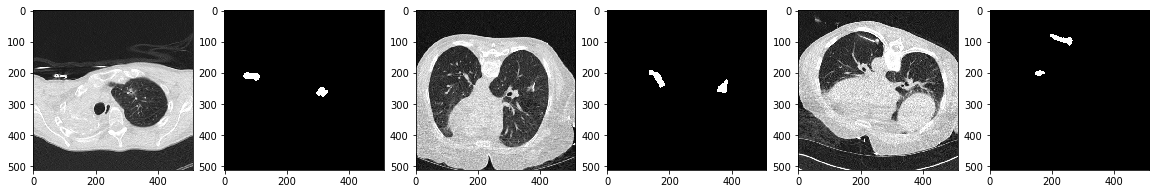

In [6]:
'''
plot problematic examples
'''

fig, ax = plt.subplots(1,6, figsize = (20,6))
ax[0].imshow(images[1], cmap='gray')
ax[1].imshow(img_masks[1], cmap='gray')
ax[2].imshow(images[15], cmap='gray')
ax[3].imshow(img_masks[15], cmap='gray')
ax[4].imshow(images[150], cmap='gray')
ax[5].imshow(img_masks[150], cmap='gray')

plt.show()


[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


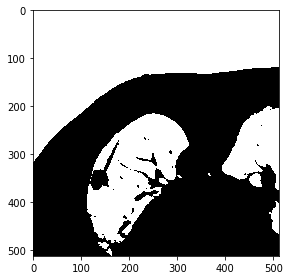

In [16]:
im = images[2]
##### BINARIZE IMAGE
# first anything <0 (as some images are negative)
im_b = np.where(im<0, 0, im)
#then based on otsu thresholding
thresh = threshold_otsu(im_b)
binary = im_b > thresh
binary = np.invert(binary)


print(binary)
imshow(binary)
#imshow(images[2])